In [65]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from helpers import create_category_map
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import multilabel_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#import scipy as sp
from sklearn.model_selection import GridSearchCV
import pickle


## Extrai dos dados e algumas características dos textos
Lê os aquivos no diretório dataset, criando um dataframe com os dados categorizados.
Depois, analisa os textos do dataframe anterior e cria um novo dataframe com os resultados anexados.
Por fim, cria um arquivo csv com os resultados para agilizar o processo, não sendo necessário rodar o código novamente.

In [66]:
#analyze_and_create_output_csv('dataset', 'output.csv')

## Lê o arquivo csv com os dados já analisados e mapeia as categorias para números

In [67]:
category_map = {'2_Ensino_Fundamental_II': 1,
 '3_Ensino_Medio': 2,
 '1_Ensino_Fundamental_I': 0,
 '4_Ensino_Superior': 3}

df = pd.read_csv('output3.csv')
df['category'] = df['category'].map(category_map)
df.dropna(inplace=True, axis=1)
df.astype({'category': 'category'}).dtypes

text                          object
passed_quality_check            bool
n_stop_words                 float64
alpha_ratio                  float64
mean_word_length             float64
                              ...   
proportion_unique_tokens     float64
n_characters                   int64
n_sentences                    int64
category                    category
name                          object
Length: 68, dtype: object

In [68]:
df

,text,passed_quality_check,n_stop_words,alpha_ratio,mean_word_length,doc_length,symbol_to_word_ratio_#,proportion_ellipsis,proportion_bullet_points,contains_lorem ipsum,...,syllables_per_token_mean,syllables_per_token_median,syllables_per_token_std,n_tokens,n_unique_tokens,proportion_unique_tokens,n_characters,n_sentences,category,name
0,"Como funciona, Origem das coisas. “É tarde! É ...",True,227.0,0.823183,4.088409,509.0,0.0,0.000000,0.0,0.0,...,1.963048,2.0,1.162748,433,247,0.570439,2081,33,1,53_2746.txt
1,A última rodada do primeiro turno do Campeonat...,True,207.0,0.843424,4.127349,479.0,0.0,0.000000,0.0,0.0,...,1.923077,2.0,1.025561,416,240,0.576923,1977,31,1,65_2775.txt
2,Em relação ao adolescente (maior de doze anos)...,False,205.0,0.869668,4.279621,422.0,0.0,0.000000,0.0,0.0,...,1.951482,2.0,1.148216,371,158,0.425876,1806,11,1,204_5035.txt
3,Curiosidades. Muitas pessoas dizem que o riso ...,True,196.0,0.868360,4.826790,433.0,0.0,0.000000,0.0,0.0,...,2.248677,2.0,1.339889,378,224,0.592593,2090,19,1,111_2840.txt
4,"O trabalho infantil, principalmente em carvoa...",True,146.0,0.867978,4.497191,356.0,0.0,0.000000,0.0,0.0,...,2.044444,2.0,1.233626,315,171,0.542857,1600,21,1,306_5137.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,Mecânica dos fluidos/Tensão superficial\nA pr...,False,186.0,0.827982,4.589450,436.0,0.0,0.333333,0.0,0.0,...,2.131148,2.0,1.348653,366,218,0.595628,2000,18,3,377_1409.txt
2072,Otimização/Método de gradientes conjugados\nE...,True,173.0,0.840399,4.738155,401.0,0.0,0.000000,0.0,0.0,...,2.213873,2.0,1.299370,346,190,0.549133,1899,24,3,451_1483.txt
2073,Mecânica dos fluidos/Exercícios resolvidos/A2\...,True,284.0,0.796000,4.245333,750.0,0.0,0.000000,0.0,0.0,...,2.033033,1.0,1.295217,666,280,0.420420,3184,28,3,292_1321.txt
2074,Logística/Movimentação de materiais/Equipament...,False,265.0,0.844311,4.968563,668.0,0.0,0.000000,0.0,0.0,...,2.312821,2.0,1.409221,585,262,0.447863,3319,25,3,263_1292.txt


## Analisa a distribuição das categorias, para verificar se há desbalanceamento

In [69]:
distribution = df.groupby('category').size()
total = distribution.sum()
weights = [distribution[i]/total for i in range(len(distribution))]
weights

[0.1430635838150289, 0.1565510597302505, 0.302504816955684, 0.3978805394990366]

In [70]:
def remove_outliers(dataframe):
        for col in dataframe.columns:
                #print(col)
                if dataframe[col].dtype == 'float64' or dataframe[col].dtype == 'int64':
                        Q1 = dataframe[col].quantile(0.25)
                        Q3 = dataframe[col].quantile(0.75)
                        IQR = Q3 - Q1
                        lower = Q1 - 1.5*IQR
                        upper = Q3 + 1.5*IQR
                        
                        dataframe = dataframe[(dataframe[col] >= lower) & (dataframe[col] <= upper)]
        return dataframe


## Executa experimentos com alguns modelos de classificação

In [71]:
from sklearn.naive_bayes import GaussianNB


#executa a codificação bag of words e separa o dataset em treino e teste
def bag_of_words_encode_split_dataset(input_column, output_column, random_state, test_size=0.2, save_vectorizer=False):
    X_train, X_test, y_train, y_test = train_test_split(input_column, output_column, test_size=test_size, random_state=random_state, stratify=output_column)

    # create bag of words representation for training set
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
        
    # create bag of words representation for test set
    X_test_counts = count_vect.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    if save_vectorizer:
        with open('count_vect', 'wb') as picklefile:
            pickle.dump(count_vect,picklefile)
        with open('tfidf_transformer', 'wb') as picklefile:
            pickle.dump(tfidf_transformer,picklefile)
        
    return X_train_tfidf, X_test_tfidf, y_train, y_test

#executa uma rodada do experimento
def run_experiment_round_bow(model, seed, input_column, output_column, save_vectorizer=False):
    X_train, X_test, y_train, y_test = bag_of_words_encode_split_dataset(input_column, output_column, test_size=0.2, random_state=seed, save_vectorizer=save_vectorizer)

    #treina modelo
    model.fit(X_train, y_train)
    
    #testa modelo
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')

def select_model(mode_name, random_state):
    if mode_name == 'random_forest':
        return RandomForestClassifier(bootstrap=False, random_state=random_state, n_jobs=8, class_weight='balanced')
    elif mode_name == 'sgd':
        return SGDClassifier(random_state=random_state, class_weight='balanced')
    elif mode_name == 'decision_tree':
        return DecisionTreeClassifier(random_state=random_state, class_weight='balanced')
    elif mode_name == 'knn':
        return KNeighborsClassifier(n_neighbors=5)
    else:
        raise Exception('Invalid model name')

def run_experiment(model_name, seeds, input_column, output_column):
    result = {'seeds': [], 'accuracy_scores': [], 'confusion_matrices': [], 'precision_scores': [], 'recall_scores': [], 'f1_scores': []}
    
    for seed in seeds:
        print(f'Round: {seed}')
        
        model = select_model(model_name, seed)
        res_accuracy_score, res_confusion_matrix, res_precision_score, res_recall_score, res_f1_score = run_experiment_round_bow(model, seed, input_column, output_column)
        
        result['accuracy_scores'].append(res_accuracy_score)
        result['confusion_matrices'].append(res_confusion_matrix)
        result['precision_scores'].append(res_precision_score)
        result['recall_scores'].append(res_recall_score)
        result['f1_scores'].append(res_f1_score)
        result['model'] = model_name
        result['seeds'].append(seed)
        
    return result

In [72]:
models = ['random_forest', 'sgd', 'decision_tree', 'knn']
results_all_models = []
for model in models:
    print(f'Running model: {model}')
    results = run_experiment(model, range(30), df['text'], df['category'])
    results_all_models.append(pd.DataFrame(results))

Running model: random_forest
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Running model: sgd
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Running model: decision_tree
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Running model: knn
Round: 0
Round: 1
Round: 2
Round: 

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [0]:

all_models_df = pd.concat(results_all_models, ignore_index=True)
all_models_df.boxplot(by=['model'], column=['accuracy_scores', 'precision_scores', 'recall_scores', 'f1_scores'],figsize=(12,8), grid=False)
plt.show()

## Exibe matrizes de confusão normalizadas médias para cada modelo

In [79]:

def show_normalized_confusion_matrix(confusion_matrix):

    normalized_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix, display_labels=[0,1,2,3])
    
    disp = disp.plot(include_values=True, cmap='YlGn', ax=None, xticks_rotation='horizontal', values_format=None)
    
    confusion_matrix_zero_diagonal = normalized_confusion_matrix.copy()
    np.fill_diagonal(confusion_matrix_zero_diagonal, 0)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_zero_diagonal, display_labels=[0,1,2,3])
    disp2 = disp2.plot(include_values=True, cmap='YlGn', ax=None, xticks_rotation='horizontal', values_format=None)

    plt.show()

def show_average_normalized_confusion_matrix(confusion_matrices):
    aggregated_confusion_matrix = confusion_matrices.sum()
    show_normalized_confusion_matrix(aggregated_confusion_matrix)

Model: random_forest


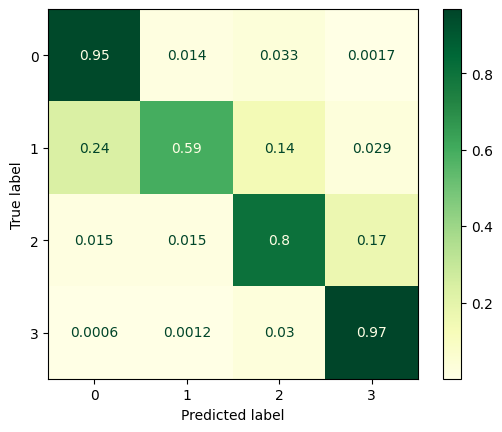

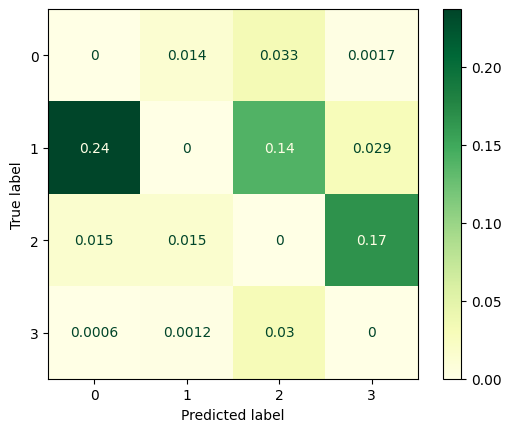

Model: sgd


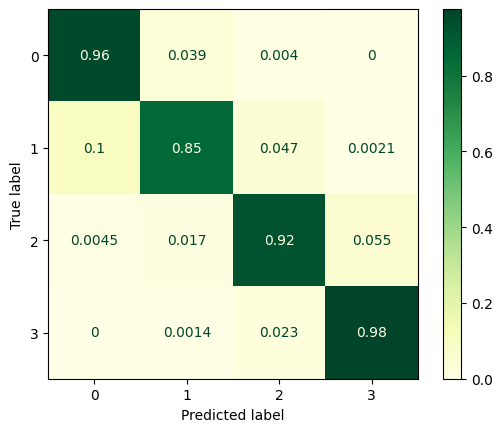

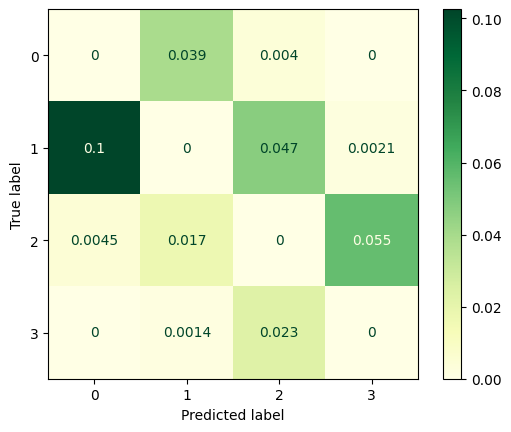

Model: decision_tree


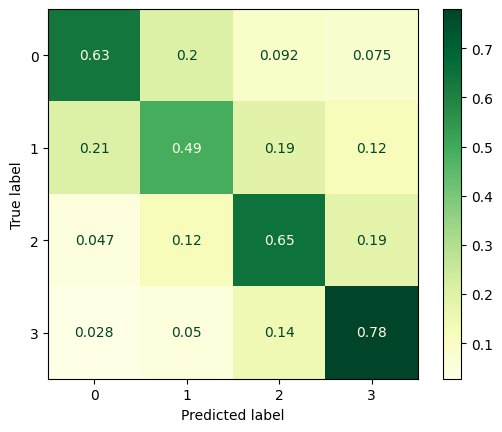

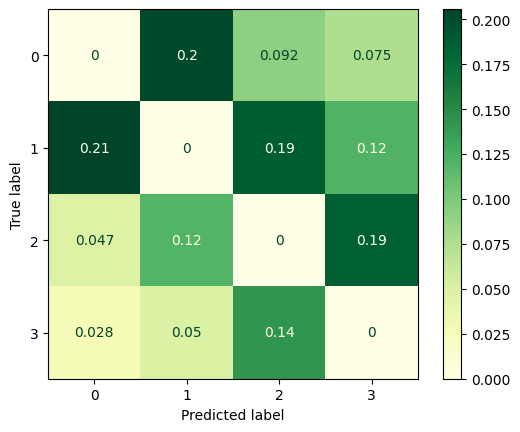

Model: knn


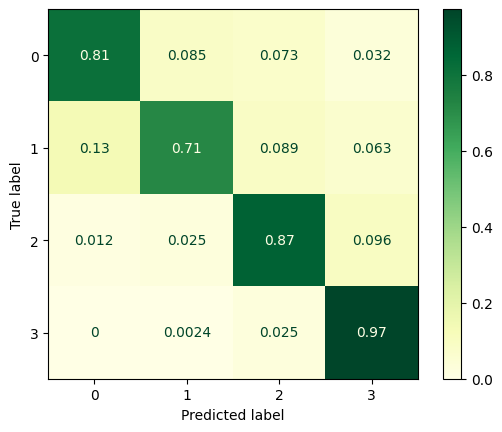

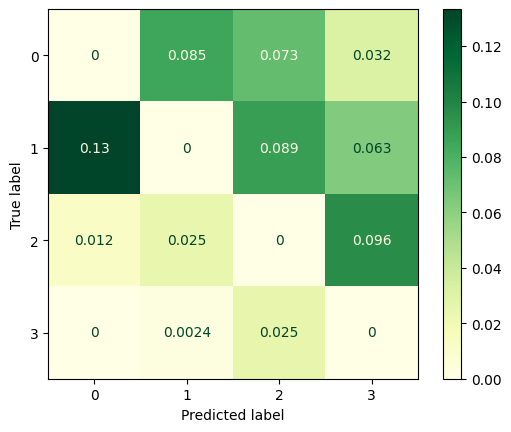

Model: naive_bayes


AttributeError: 'int' object has no attribute 'astype'

In [80]:
for model in models:
    print(f'Model: {model}')
    show_average_normalized_confusion_matrix(all_models_df[all_models_df['model'] == model]['confusion_matrices'])

## Verifica qual foi o melhor modelo e exibe sua matriz de confusão

seeds                                                                25
accuracy_scores                                                0.961538
confusion_matrices    [[59, 0, 0, 0], [2, 60, 3, 0], [0, 2, 118, 6],...
precision_scores                                               0.962766
recall_scores                                                  0.960378
f1_scores                                                      0.961337
model                                                               sgd
Name: 55, dtype: object


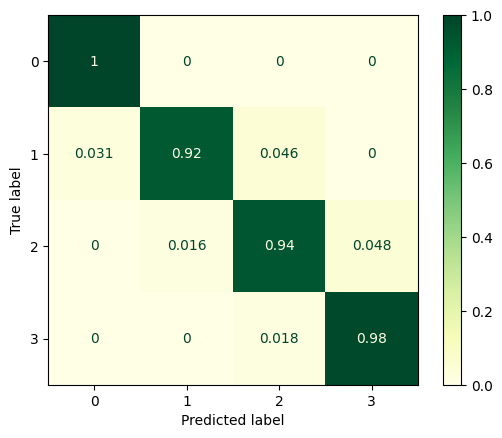

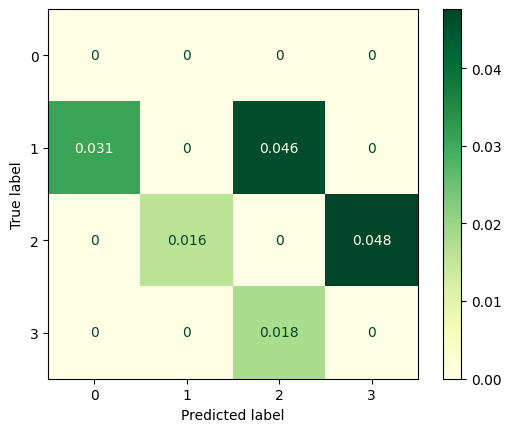

In [81]:
best_model = all_models_df.iloc[all_models_df['accuracy_scores'].idxmax()]
best_model_cm = best_model['confusion_matrices']
print(best_model)

show_normalized_confusion_matrix(best_model_cm)
best_seed = best_model['seeds']

## Refina o modelo com o melhor resultado

In [ ]:

def perform_grid_search_cv(dataframe, seed):
        param_grid = [
       # {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        #{'bootstrap': [False, True], 'n_estimators': [10, 50, 100, 200], 'max_features': [10, 100, 1000 ]}]
        {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive'], 'max_iter': [500, 1000, 2000, 5000]}]
        
        clf = SGDClassifier(random_state=seed, class_weight='balanced')
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=3)
        
        X_train, X_test, y_train, y_test = bag_of_words_encode_split_dataset(dataframe['text'], dataframe['category'], test_size=0.2, random_state=seed)

        grid_search.fit(X_train, y_train)

        return grid_search

In [ ]:
gs = perform_grid_search_cv(df, best_seed)
gs.best_params_

In [ ]:

models2 = ['sgd']
model = SGDClassifier(random_state=best_seed, class_weight='balanced')

results = run_experiment_round_bow(model, best_seed, df['text'], df['category'], save_vectorizer=True)
results_df = pd.DataFrame(results)
show_average_normalized_confusion_matrix(results_df.iloc[1])


#results_all_models2

In [ ]:
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(model,picklefile)

with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)
    results = run_experiment_round_bow(model, best_seed, df['text'], df['category'])
    results_df = pd.DataFrame(results)
    print(results_df)